# GANs Kaggle Mini-Project

## Imports and configs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, ReLU, LeakyReLU, Activation, Add, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import PIL

BASE_PATH = "data"
OUT_PATH = "submission"
IMAGE_SIZE = [256, 256]
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Utils for loading the data

*these functions were created by [Amy Jang](https://www.kaggle.com/amyjang)*

In [2]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

## Brief description of the problem and data

The goal of this project is to build a Generative Adversarial Network (GAN) that generates images in the style of Monet. The idea is to use a CycleGAN architecture, creating a generator and a discriminator. Then the model will be trained with actual Monet paintings and it will be used to transform normal photos in Monet's art afterwards.

The data is composed of 2 directories: **monet_tfrec** and **photo_tfrec**. The monet_tfrec directory contains Monet paintings and the photo_tfrec directory contains normal photos.

### Monet images

**300** Monet paintings sized 256 x 256 in TFRecord format

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(BASE_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord files:', len(MONET_FILENAMES))
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)

Monet TFRecord files: 5


2024-06-21 19:37:27.180723: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-21 19:37:27.180738: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-21 19:37:27.180742: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-21 19:37:27.180765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-21 19:37:27.180778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


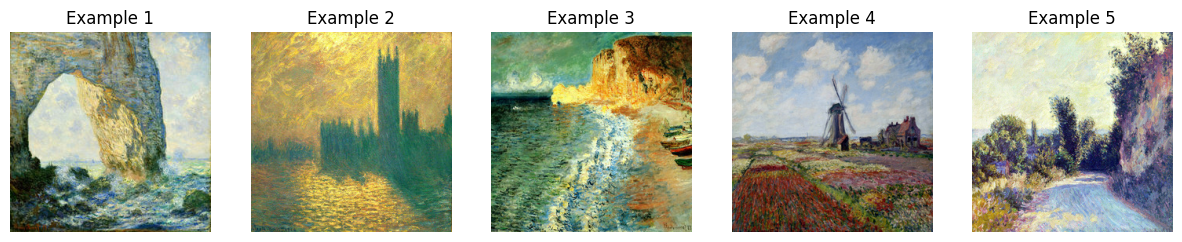

In [4]:
_, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(monet_ds.take(5)):
    ax[i].set_title(f'Example {i+1}')
    ax[i].imshow(img[0] * 0.5 + 0.5)
    ax[i].axis('off')

### Normal photos

**7028** photos sized 256 x 256 in TFRecord format

In [5]:
PHOTO_FILENAMES = tf.io.gfile.glob(str(BASE_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord files:', len(PHOTO_FILENAMES))
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Photo TFRecord files: 20


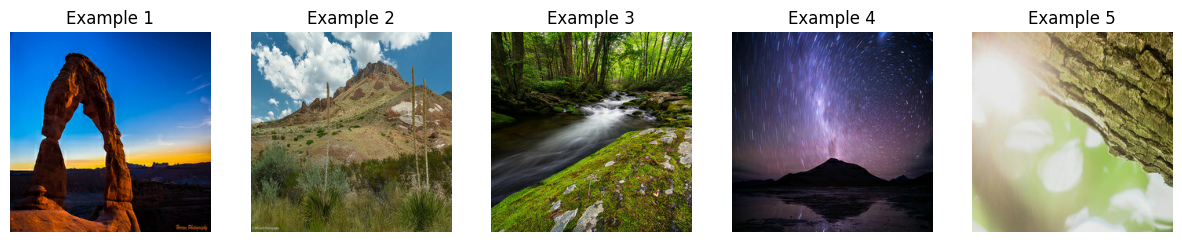

In [6]:
_, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(photo_ds.take(5)):
    ax[i].set_title(f'Example {i+1}')
    ax[i].imshow(img[0] * 0.5 + 0.5)
    ax[i].axis('off')

## Model architecture

The idea is to implement a CycleGAN architecture using TensorFlow/Keras for translating images between Monet paintings and photographs. It includes custom generator and discriminator architectures, various loss functions tailored for adversarial training and cycle consistency, and a training loop that optimizes these networks over multiple epochs. The use of residual blocks and skip connections aims to help in stabilizing and improving the training of the generator networks.

### Building the generator and discriminator

**Generator**

- Downsampling Stack (down_stack): Consists of three convolutional blocks (conv_block) with decreasing spatial dimensions and increasing number of filters (64, 128, 256). These blocks downsample the input image.
- Residual Blocks (res_blocks): Five residual blocks (residual_block) are used to enhance the features extracted by the downsampling layers.
- Upsampling Stack (up_stack): Contains two transpose convolutional blocks (conv_transpose_block) that upsample the image back to the original size.
- Output Layer: A final transpose convolutional layer that generates an image with the same dimensions as the input image.

**Discriminator**

- Sequentially applies convolutional blocks (conv_block) with increasing filters (64, 128, 256, 512) to distinguish real and generated images.
- The final output is a single-channel image (after a convolution layer with 1 filter) representing the discriminator's classification.

In [ ]:
def conv_block(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

def residual_block(filters, size=3):
    initializer = tf.random_normal_initializer(0., 0.02)
    def block(x):
        y = Conv2D(filters, size, padding='same', kernel_initializer=initializer, use_bias=False)(x)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, size, padding='same', kernel_initializer=initializer, use_bias=False)(y)
        y = BatchNormalization()(y)
        y = Add()([x, y])
        return ReLU()(y)
    return block

def conv_transpose_block(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

def build_generator():
    down_stack = [
        conv_block(64, 4, apply_batchnorm=False),
        conv_block(128, 4),
        conv_block(256, 4)
    ]
    res_blocks = [
        residual_block(256),
        residual_block(256),
        residual_block(256),
        residual_block(256),
        residual_block(256)
    ]
    up_stack = [
        conv_transpose_block(128, 4, apply_dropout=True),
        conv_transpose_block(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    input_img = Input(shape=[256, 256, 3])
    x = input_img
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    for res in res_blocks:
        x = res(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    output_img = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')(x)
    return Model(input_img, output_img)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    input_img = Input(shape=[256, 256, 3])
    x = conv_block(64, 4, apply_batchnorm=False)(input_img)
    for filters in [128, 256, 512]:
        x = conv_block(filters, 4)(x)
    output_img = Conv2D(1, kernel_size=4, padding='same', kernel_initializer=initializer)(x)
    return Model(input_img, output_img)

### Loss functions

**Binary Crossentropy Loss**

- discriminator_loss: Computes the adversarial loss for the discriminator.
- generator_loss: Computes the adversarial loss for the generator.

**Cycle Consistency Loss**

- Measures the difference between the original image and the image reconstructed after passing through both generators (Monet-to-Photo-to-Monet and vice versa).

**Identity Loss**

- Ensures that the generator maps an input image close to itself. This loss helps preserve the input's characteristics.

**Perceptual Loss**

- Utilizes a pre-trained VGG19 model to measure the perceptual similarity between the generated and real images.

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image, lambda_cycle):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss1

def identity_loss(real_image, same_image, lambda_identity):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_identity * 0.5 * loss

def perceptual_loss(y_true, y_pred):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    loss_model = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv2').output)
    loss_model.trainable = False
    y_true_features = loss_model(y_true)
    y_pred_features = loss_model(y_pred)
    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

### Building the CycleGAN model

**Initialization**

- Constructs two generators (m_gen and p_gen) and two discriminators (m_disc and p_disc).
- Defines hyperparameters (lambda_cycle and lambda_identity) that control the importance of cycle consistency and identity losses.

**Training Loop**

- Takes a batch of real Monet paintings and real photographs as input.
- Uses gradient tape to compute losses and gradients for both generators and discriminators.
- Optimizes the networks using Adam optimizer with learning rate scheduling (ExponentialDecay).
- Returns losses for Monet and Photo generators and discriminators after each training step.

In [8]:
class CycleGan(tf.keras.Model):
    def __init__(self, lambda_cycle=10.0, lambda_identity=0.5):
        super(CycleGan, self).__init__()
        self.m_gen = build_generator() # monet_generator
        self.p_gen = build_generator() # photo_generator
        self.m_disc = build_discriminator() # monet_discriminator
        self.p_disc = build_discriminator() # photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, **kwargs):
        super(CycleGan, self).compile(**kwargs)
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        
    def train_step(self, data):
        real_monet, real_photo = data
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            monet_gen_loss = generator_loss(disc_fake_monet)
            photo_gen_loss = generator_loss(disc_fake_photo)
            total_cycle_loss = cycle_loss(real_monet, cycled_monet, self.lambda_cycle) + cycle_loss(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + identity_loss(real_monet, same_monet, self.lambda_identity)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + identity_loss(real_photo, same_photo, self.lambda_identity)
            monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
            photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Training the model

**Compiling the Model**

- Sets up the model with Adam optimizers for both generator and discriminator networks.
- Uses perceptual_loss as the overall loss function.

**Fitting the Model**

- Trains the CycleGAN model using datasets (monet_ds and photo_ds) containing Monet paintings and photographs respectively.
- Executes for 30 epochs with early stopping based on the monet_gen_loss.

In [9]:
lr_schedule = ExponentialDecay(initial_learning_rate=2e-4, decay_steps=900, decay_rate=0.9, staircase=True)

cycle_gan_model = CycleGan()
cycle_gan_model.compile(
    m_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, beta_1=0.5),
    p_gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, beta_1=0.5),
    m_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, beta_1=0.5),
    p_disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, beta_1=0.5),
    loss = perceptual_loss
)

cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=30, callbacks=[tf.keras.callbacks.EarlyStopping(patience=6, monitor='monet_gen_loss')])

Epoch 1/30


2024-06-21 19:37:30.812899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 124s 395ms/step - monet_gen_loss: 4.9108 - photo_gen_loss: 4.9041 - monet_disc_loss: 0.6989 - photo_disc_loss: 0.7056
Epoch 2/30


2024-06-21 19:39:32.175490: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12086114894051053890
2024-06-21 19:39:32.175523: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13840565726365946454
2024-06-21 19:39:32.175535: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1522198203463889805
2024-06-21 19:39:32.175689: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1228235027545843338


300/300 [==============================] - 118s 392ms/step - monet_gen_loss: 3.4357 - photo_gen_loss: 3.3983 - monet_disc_loss: 0.6700 - photo_disc_loss: 0.6849
Epoch 3/30
300/300 [==============================] - 118s 393ms/step - monet_gen_loss: 3.1261 - photo_gen_loss: 3.1301 - monet_disc_loss: 0.6710 - photo_disc_loss: 0.6723
Epoch 4/30
300/300 [==============================] - 118s 393ms/step - monet_gen_loss: 3.0750 - photo_gen_loss: 3.1108 - monet_disc_loss: 0.6738 - photo_disc_loss: 0.6609
Epoch 5/30
300/300 [==============================] - 118s 392ms/step - monet_gen_loss: 3.0166 - photo_gen_loss: 3.0662 - monet_disc_loss: 0.6755 - photo_disc_loss: 0.6672
Epoch 6/30
300/300 [==============================] - 118s 393ms/step - monet_gen_loss: 2.9264 - photo_gen_loss: 2.9963 - monet_disc_loss: 0.6835 - photo_disc_loss: 0.6666
Epoch 7/30
300/300 [==============================] - 118s 393ms/step - monet_gen_loss: 2.8306 - photo_gen_loss: 2.8988 - monet_disc_loss: 0.6820 - pho

## Results

### Metrics per epoch of training

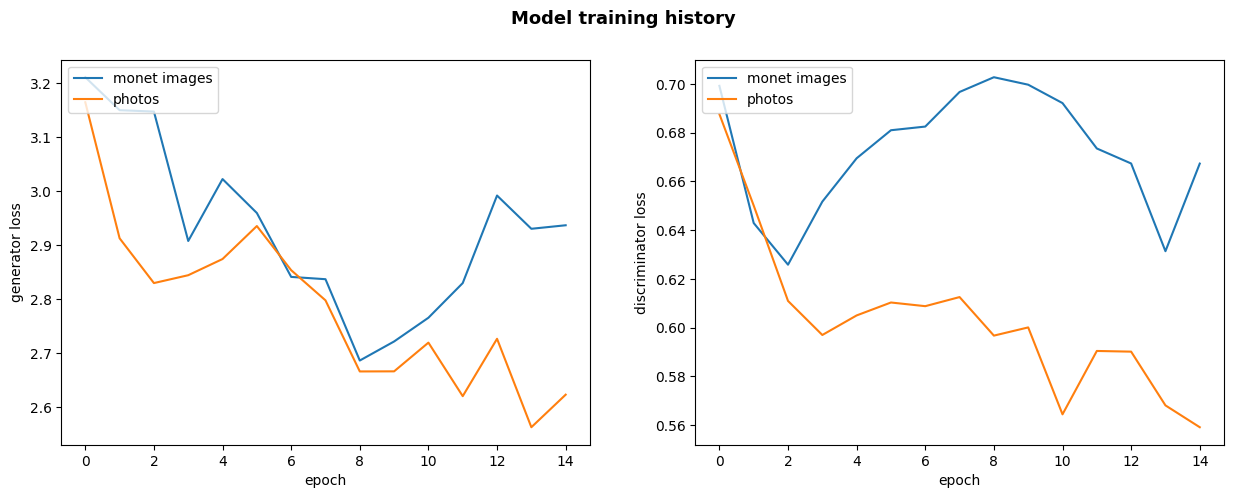

In [14]:
h = cycle_gan_model.history.history

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f"Model training history", fontsize=13, fontweight='bold')

axs[0].plot(h['monet_gen_loss'], label='monet images')
axs[0].plot(h['photo_gen_loss'], label='photos')
axs[0].set_ylabel('generator loss')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper left')

axs[1].plot(h['monet_disc_loss'], label='monet images')
axs[1].plot(h['photo_disc_loss'], label='photos')
axs[1].set_ylabel('discriminator loss')
axs[1].set_xlabel('epoch')
axs[1].legend(loc='upper left')

### Monet generator examples

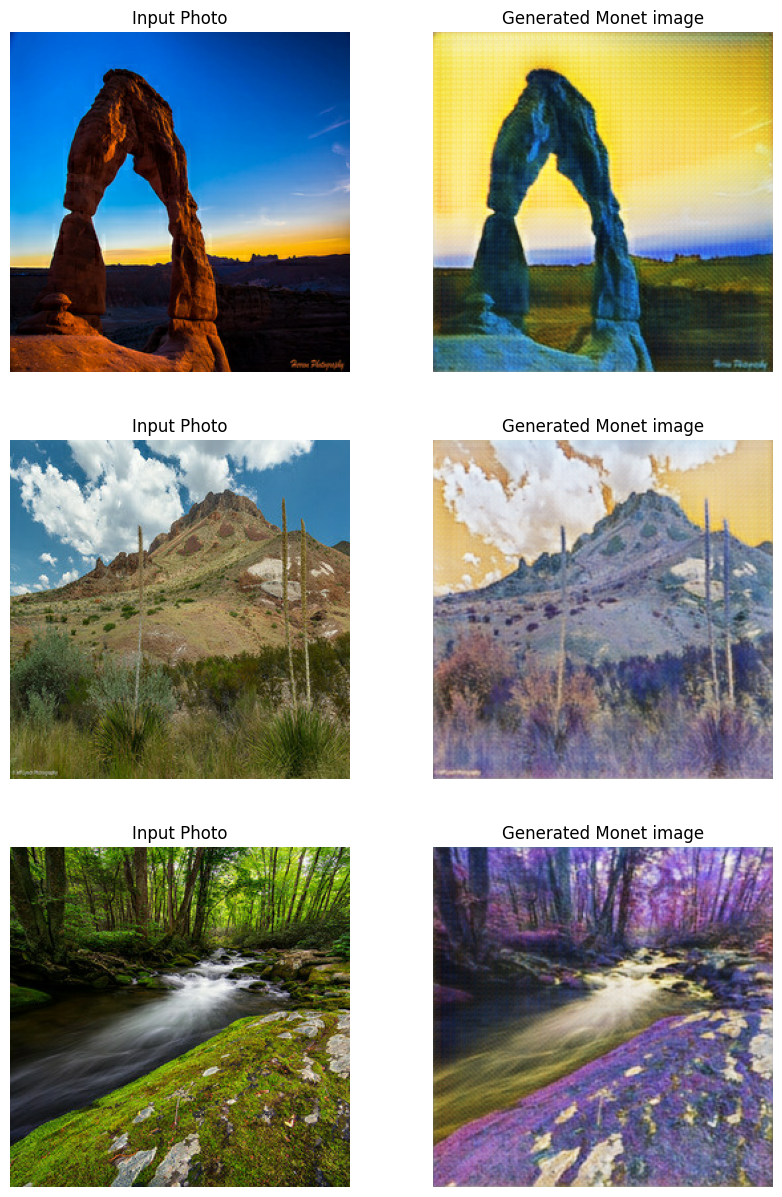

In [15]:
_, ax = plt.subplots(3, 2, figsize=(10, 15))
for i, img in enumerate(photo_ds.take(3)):
    prediction = cycle_gan_model.m_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Generated Monet image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Submission

In [12]:
for i,img in enumerate(photo_ds):
    prediction = cycle_gan_model.m_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(OUT_PATH + "/" + str(i+1) + ".jpg")

## Conclusion

GANs are powerful tools for generating synthetic data that closely resembles real data. CycleGANs extend this concept by introducing cycle consistency, enabling bidirectional translation between two domains without paired examples. The dual nature of CycleGANs, with two generators and two discriminators, facilitates learning transformations that preserve essential content while adapting the style.

I explored the construction of generators using downsampling, residual blocks, and upsampling layers. This design efficiently captures and reconstructs features across different scales, crucial for high-quality image translation. The discriminators were designed to discern between real and generated images, aiding the generators in improving the quality and realism of the produced images.

The training loop employed a balance between optimizing generators and discriminators, ensuring stable and progressive learning. Learning rate scheduling and careful management of optimizer parameters played a crucial role in converging to optimal solutions.

Training GANs can be unstable, but techniques like gradient clipping and monitoring losses can mitigate issues. The inclusion of perceptual loss using a pre-trained model (VGG19) highlighted the importance of perceptual similarity over pixel-wise differences, yielding more visually pleasing results. Leveraging pre-trained models for perceptual loss demonstrates the value of transfer learning. It allows us to incorporate high-level feature representations without requiring extensive training data.